In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, Column, Integer, Text

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()

In [7]:
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [19]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)
# session = Session()

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

In [44]:
# Find the most recent date in the data set.
most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = pd.to_datetime(most_recent_date_row[0])  # Convert the date string to a datetime object

# Calculate the date one year prior
one_year_prior = most_recent_date - pd.DateOffset(months=12)

In [46]:
# If Measurement.date is a string in 'YYYY-MM-DD' format
one_year_prior_str = one_year_prior.strftime('%Y-%m-%d')

In [48]:
# Now, to retrieve the last 12 months of precipitation data:
last_year_precipitation_query = session.query(Measurement).filter(Measurement.date >= one_year_prior_str).all()

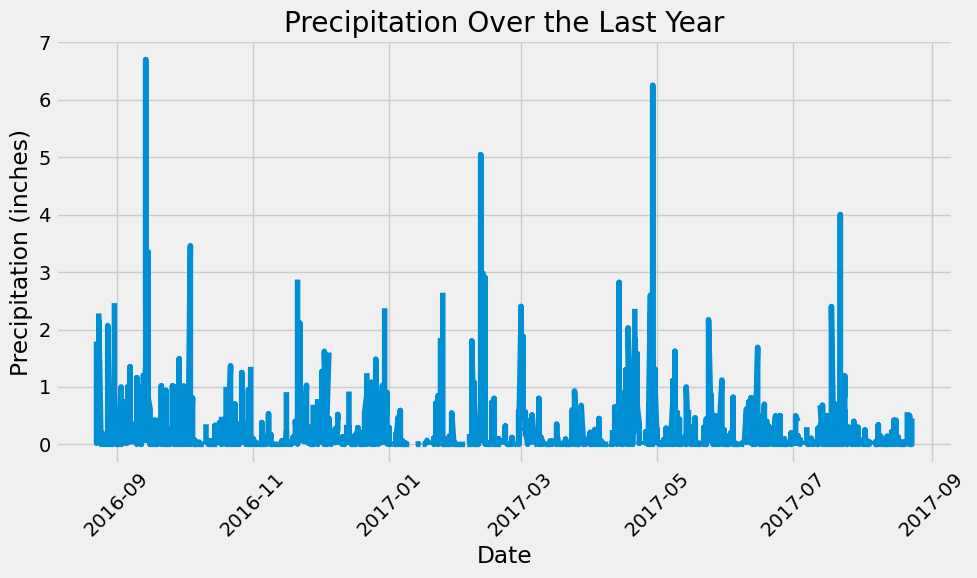

In [51]:
# Retrieve the last 12 months of precipitation data:
last_year_precipitation_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_prior_str).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data = pd.DataFrame(last_year_precipitation_query, columns=['date', 'prcp'])

# Sort the DataFrame by date
precipitation_data['date'] = pd.to_datetime(precipitation_data['date'])  # Ensure the date column is in datetime format
precipitation_data.sort_values(by='date', inplace=True)  # Sort by the date column

# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(precipitation_data['date'], precipitation_data['prcp'], linestyle='-')
plt.title('Precipitation Over the Last Year')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [52]:
# Calculate summary statistics for the precipitation data
summary_statistics = precipitation_data['prcp'].describe()

# Print the summary statistics
print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [53]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()

# Print the total number of stations
print(f'Total number of stations: {total_stations}')
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

Total number of stations: 9


In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station).count(Station)

[(9,)]

In [54]:
from sqlalchemy import func

In [57]:
# Design a query to find the most active stations
most_active_stations_query = session.query(
    Station.station,  # Assuming 'station' is the identifier for the station
    func.count(Measurement.station).label('station_count')  # Count the number of observations for each station
).join(Measurement, Station.station == Measurement.station)  # Join with the Measurement table

# Group by the station and order by the count in descending order
most_active_stations_query = most_active_stations_query.group_by(Station.station).order_by(func.count(Measurement.station).desc()).all()

# Print the most active stations and their counts
print("Most Active Stations:")
for station, station_count in most_active_stations_query:
    print(f'Station: {station}, Count: {station_count}')

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [58]:
# Get the most active station from the previous query
most_active_station = most_active_stations_query[0][0]  # Assuming the first entry is the most active station

# Design a query to calculate the lowest, highest, and average temperatures for the most active station
temperature_stats_query = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station).all()

# Extract the results
min_temp, max_temp, avg_temp = temperature_stats_query[0]

# Print the temperature statistics
print(f'Temperature Statistics for Station {most_active_station}:')
print(f'Lowest Temperature: {min_temp}')
print(f'Highest Temperature: {max_temp}')
print(f'Average Temperature: {avg_temp}')

Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


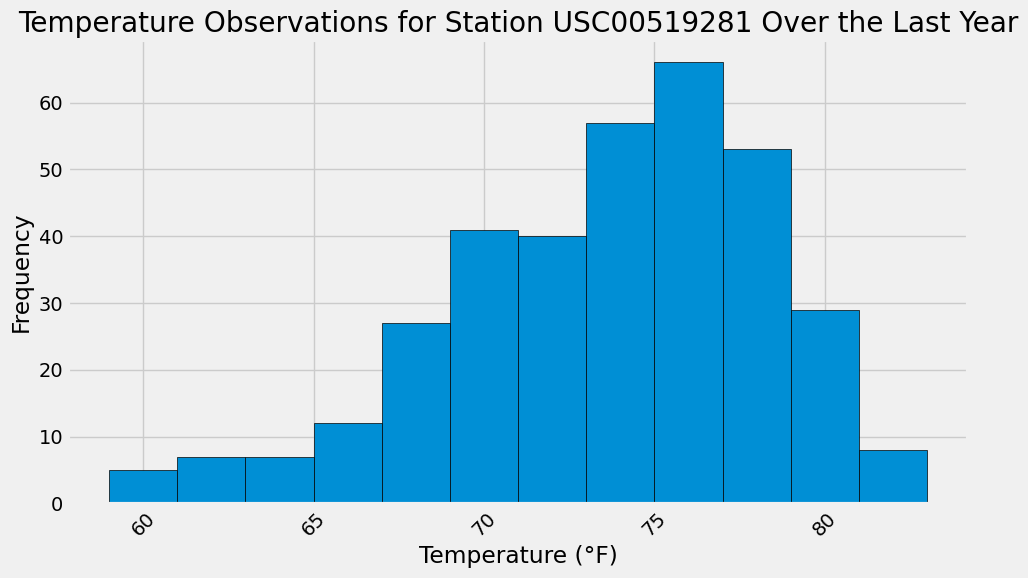

In [59]:
# Assuming you have already determined the most active station
most_active_station = most_active_stations_query[0][0]  # Get the most active station ID

# Find the most recent date in the dataset
most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = pd.to_datetime(most_recent_date_row[0])  # Convert to datetime

# Calculate the date one year prior
one_year_prior = most_recent_date - pd.DateOffset(months=12)
one_year_prior_str = one_year_prior.strftime('%Y-%m-%d')

# Query the last 12 months of temperature observation data for this station
last_year_tobs_query = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station,
    Measurement.date >= one_year_prior_str
).all()

# Convert the query results to a Pandas DataFrame
tobs_data = pd.DataFrame(last_year_tobs_query, columns=['tobs'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(tobs_data['tobs'], bins=12, edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station} Over the Last Year')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()